In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data

**Observations**

In [4]:
nateForcingFileHTG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'
nateDS_HTG = xr.open_dataset(nateForcingFileHTG, decode_times='True')

nateForcingFileHMG = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateDS_HMG = xr.open_dataset(nateForcingFileHMG, decode_times='True')


**Artificial surface**

In [6]:
## Read in CLM files 

# dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/'

# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_'

# This version also outputs the buoyancy term, rt'thv', tau, and uses theta (not theta_v) for HTG additions
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/artificialSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_artificialSfc_plusBuoyancyTau_useTheta_'



yearStrings  = np.asarray(['2015','2016','2017','2018'])
dateEndFiles = np.asarray([ '-05-31-84585.nc',
                            '-06-09-56985.nc',
                            '-06-18-29385.nc',
                            '-06-27-01785.nc',
                            '-07-05-60585.nc',
                            '-07-14-32985.nc',
                            '-07-23-05385.nc',
                            '-07-31-64185.nc',
                            '-08-09-36585.nc',
                            '-08-18-08985.nc',
                            '-08-26-67785.nc' ])

fileCount=0
for iYr in range(len(yearStrings)): 
    
    fileStart_atm_HMG = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    fileStart_atm_HTG = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'+yearStrings[iYr]
    
    for iFile in range(len(dateEndFiles)):
        
        fileName_atm_HMG = fileStart_atm_HMG+dateEndFiles[iFile]
        fileName_atm_HTG = fileStart_atm_HTG+dateEndFiles[iFile]
        
        with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
            HMG_camDS = cesm_correct_time(HMG_camDS)
            HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
        with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
            HTG_camDS = cesm_correct_time(HTG_camDS)
            HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
            
         
        # Discard the first two days if iFile == 0  
        if iFile==0:
            iTimeStart   = np.where(HTG_camDS.time.values >= (HTG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
            timeArr      = np.arange(iTimeStart[0], len(HTG_camDS.time.values))

            HTG_camDS      = HTG_camDS.isel(time=timeArr)
            HMG_camDS      = HMG_camDS.isel(time=timeArr)
            

        if fileCount==0:
            HTGcamDS_all = HTG_camDS
            HMGcamDS_all = HMG_camDS
            
        else: 
            HTGcamDS_all = xr.concat([HTGcamDS_all,HTG_camDS], dim='time')
            HMGcamDS_all = xr.concat([HMGcamDS_all,HMG_camDS], dim='time')
            
        
        fileCount = fileCount+1
        print('Done with file %i of %i '% (fileCount,len(yearStrings)*len(dateEndFiles)))



Done with file 1 of 44 
Done with file 2 of 44 
Done with file 3 of 44 
Done with file 4 of 44 
Done with file 5 of 44 
Done with file 6 of 44 
Done with file 7 of 44 
Done with file 8 of 44 
Done with file 9 of 44 
Done with file 10 of 44 
Done with file 11 of 44 
Done with file 12 of 44 
Done with file 13 of 44 
Done with file 14 of 44 
Done with file 15 of 44 
Done with file 16 of 44 
Done with file 17 of 44 
Done with file 18 of 44 
Done with file 19 of 44 
Done with file 20 of 44 
Done with file 21 of 44 
Done with file 22 of 44 
Done with file 23 of 44 
Done with file 24 of 44 
Done with file 25 of 44 
Done with file 26 of 44 
Done with file 27 of 44 
Done with file 28 of 44 
Done with file 29 of 44 
Done with file 30 of 44 
Done with file 31 of 44 
Done with file 32 of 44 
Done with file 33 of 44 
Done with file 34 of 44 
Done with file 35 of 44 
Done with file 36 of 44 
Done with file 37 of 44 
Done with file 38 of 44 
Done with file 39 of 44 
Done with file 40 of 44 
Done with

In [7]:
## Add evaporative fraction to DS 
HTG_EF = HTGcamDS_all.LHFLX.values / (HTGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)
HMG_EF = HMGcamDS_all.LHFLX.values / (HMGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)

HTGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HTG_EF))
HMGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HMG_EF))



In [8]:
## Define the actual vertical velocity skew, not just the third order moment 
skw_W_HTG = HTGcamDS_all.WP3_CLUBB.values / ((HTGcamDS_all.WP2_CLUBB.values)**1.5)
skw_W_HMG = HMGcamDS_all.WP3_CLUBB.values / ((HMGcamDS_all.WP2_CLUBB.values)**1.5)

HTGcamDS_all['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HTG))
HMGcamDS_all['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HMG))



In [9]:
## Convert to local times...
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)
HTGcamDS_local       = HTGcamDS_all.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})

print('First four times in UTC:\n', HMGcamDS_all.time.values[0:5])
print('Now in local time (CDT):\n', HMGcamDS_local.time.values[0:5])


First four times in UTC:
 ['2015-06-02T23:32:15.000000000' '2015-06-02T23:37:15.000000000'
 '2015-06-02T23:42:15.000000000' '2015-06-02T23:47:15.000000000'
 '2015-06-02T23:52:15.000000000']
Now in local time (CDT):
 ['2015-06-02T18:32:15.000000000' '2015-06-02T18:37:15.000000000'
 '2015-06-02T18:42:15.000000000' '2015-06-02T18:47:15.000000000'
 '2015-06-02T18:52:15.000000000']


In [10]:
HMGcamDS_allArtifical = HMGcamDS_local
HTGcamDS_allArtifical = HTGcamDS_local

## Make some plots from obs alone

In [11]:
nateDS_HTG['WindMagnitude'] = (('time','lev'), np.sqrt((nateDS_HTG.u.values**2) + (nateDS_HTG.v.values**2)))
nateDS_HMG['WindMagnitude'] = (('time','lev'), np.sqrt((nateDS_HMG.u.values**2) + (nateDS_HMG.v.values**2)))


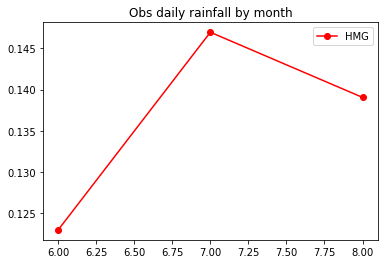

In [12]:
# June mean rain: 
iYears = np.where((nateDS_HTG["time.year"]>=2015) & (nateDS_HTG["time.year"]<=2018))[0]
nateDS_HTG = nateDS_HTG.isel(time=iYears)

iJune = np.where(nateDS_HTG["time.month"].values==6)[0]
iJuly = np.where(nateDS_HTG["time.month"].values==7)[0]
iAug  = np.where(nateDS_HTG["time.month"].values==8)[0]

HMGrain_june = np.nanmean(nateDS_HTG.prec_srf.values[iJune])

HMGrain_july = np.nanmean(nateDS_HTG.prec_srf.values[iJuly])

HMGrain_aug  = np.nanmean(nateDS_HTG.prec_srf.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.title('Obs daily rainfall by month')
plt.legend(['HMG','HTG'])


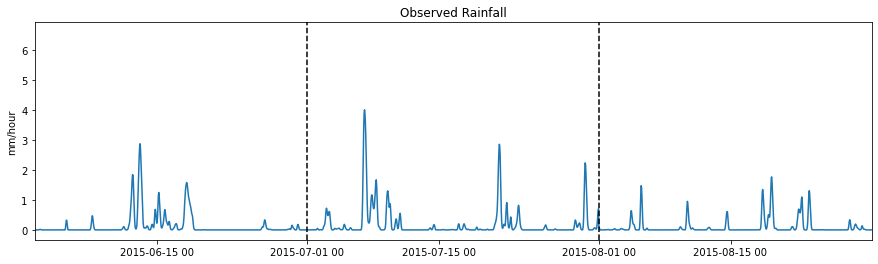

In [87]:
fig,axs = plt.subplots(1,1, figsize=(15,4))
axs.plot(nateDS_HTG.time.values, nateDS_HTG.prec_srf.values)
axs.set_title('Observed Rainfall')
axs.set_ylabel(nateDS_HTG.prec_srf.units)

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

# axs.axhline(1, color = 'grey', linestyle = ':')


plt.show()

In [78]:
nateDS_HTG

<xarray.Dataset>
Dimensions:        (lev: 37, time: 33600)
Coordinates:
  * time           (time) datetime64[ns] 2015-01-01 ... 2018-10-31T22:49:25.4...
  * lev            (lev) float32 1e+03 975.0 950.0 925.0 ... 150.0 125.0 100.0
Data variables:
    base_time      datetime64[ns] ...
    time_offset    (time) datetime64[ns] ...
    year           (time) float64 ...
    month          (time) float64 ...
    day            (time) float64 ...
    hour           (time) float64 ...
    minute         (time) float64 ...
    lat            float32 ...
    lon            float32 ...
    alt            float32 ...
    phis           float32 ...
    T              (time, lev) float32 ...
    q              (time, lev) float32 ...
    u              (time, lev) float32 1.514 1.514 2.491 ... 33.43 28.33 23.6
    v              (time, lev) float32 0.833 0.833 1.197 ... 21.98 16.57 12.72
    omega          (time, lev) float32 ...
    div            (time, lev) float32 ...
    T_adv_h        (time, lev) float32 ...
    T_adv_v        (time, lev) float32 ...
    q_adv_h        (time, lev) float32 ...
    q_adv_v        (time, lev) float32 ...
    s              (time, lev) float32 ...
    s_adv_h        (time, lev) float32 ...
    s_adv_v        (time, lev) float32 ...
    dsdt           (time, lev) float32 ...
    dTdt           (time, lev) float32 ...
    dqdt           (time, lev) float32 ...
    q1             (time, lev) float32 ...
    q2             (time, lev) float32 ...
    prec_srf       (time) float32 ...
    LH             (time) float32 ...
    SH             (time) float32 ...
    p_srf_aver     (time) float32 ...
    p_srf_center   (time) float32 ...
    T_srf          (time) float32 ...
    T_soil         (time) float32 ...
    RH_srf         (time) float32 ...
    wspd_srf       (time) float32 ...
    u_srf          (time) float32 ...
    v_srf          (time) float32 ...
    rad_net_srf    (time) float32 ...
    lw_net_toa     (time) float32 ...
    sw_net_toa     (time) float32 ...
    sw_dn_toa      (time) float32 ...
    cld_low        (time) float32 ...
    cld_mid        (time) float32 ...
    cld_high       (time) float32 ...
    cld_tot        (time) float32 ...
    cld_thick      (time) float32 ...
    cld_top        (time) float32 ...
    LWP            (time) float32 ...
    dh2odt_col     (time) float32 ...
    h2o_adv_col    (time) float32 ...
    evap_srf       (time) float32 ...
    dsdt_col       (time) float32 ...
    s_adv_col      (time) float32 ...
    rad_heat_col   (time) float32 ...
    LH_col         (time) float32 ...
    omega_srf      (time) float32 ...
    q_srf          (time) float32 ...
    s_srf          (time) float32 ...
    PW             (time) float32 ...
    lw_up_srf      (time) float32 ...
    lw_dn_srf      (time) float32 ...
    sw_up_srf      (time) float32 ...
    sw_dn_srf      (time) float32 ...
    T_skin         (time) float32 ...
    TEST           (time) float64 ...
    wpqtp_sfc      (time) float32 ...
    wpthlp_sfc     (time) float32 ...
    qp2            (time) float32 ...
    thlp2          (time) float32 ...
    thlpqp         (time) float32 ...
    wp2            (time) float32 ...
    wp4            (time) float32 ...
    wp2thetap      (time) float32 ...
    wp2qp          (time) float32 ...
    wpqp2          (time) float32 ...
    wpthetap2      (time) float32 ...
    wpthetapqp     (time) float32 ...
    wp3            (time) float32 ...
    upwp           (time) float32 ...
    vpwp           (time) float32 ...
    WindMagnitude  (time, lev) float32 1.728 1.728 2.763 ... 40.01 32.82 26.81
Attributes:
    Conventions:   CF-1.7
    title:         VarAna 1hr RAP_Based v2: SGP 2015-01
    history:       Mon Feb 17 20:27:23 2020: ncrcat sgp60varanarapC1.c1.20150...
    update:        surface LH and SH are merged from ECOR and EBBR instruments
    date_created:  Thu Apr 13 20:12:17 2017
    contact:       Shuaiqi Tang: tang32@llnl.gov, Qi Tang: tang30@llnl.gov, Y...


**RUN THE BELOW GRIDCELL** to get local time obs 

In [12]:
nateDS_local       = nateDS_HTG.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = nateDS_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
nateDS_local = nateDS_local.assign_coords({"time": localTimes})

# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([nateDS_local['time.year'].values,
                                                                nateDS_local['time.month'].values, 
                                                                nateDS_local['time.day'].values])
nateDS_local.coords['year_month_day'] = ('time', month_day_idx)

# Now sum over the day to get total amount of rainfall
nateDS_localDailySum = nateDS_local.groupby('year_month_day').sum()


(1.0, 6.0)

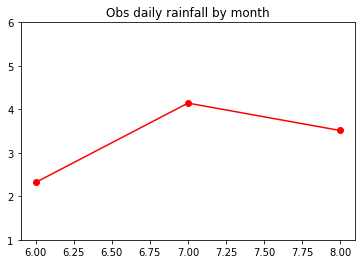

In [31]:
# June mean rain: 
iJune = np.where( (nateDS_localDailySum.year_month_day_level_0.values==2016) &
                  (nateDS_localDailySum.year_month_day_level_1.values==6))[0]
iJuly = np.where( (nateDS_localDailySum.year_month_day_level_0.values==2016) &
                  (nateDS_localDailySum.year_month_day_level_1.values==7))[0]
iAug  = np.where( (nateDS_localDailySum.year_month_day_level_0.values==2016) &
                  (nateDS_localDailySum.year_month_day_level_1.values==8))[0]

HMGrain_june = np.nanmean(nateDS_localDailySum.prec_srf.values[iJune])

HMGrain_july = np.nanmean(nateDS_localDailySum.prec_srf.values[iJuly])

HMGrain_aug  = np.nanmean(nateDS_localDailySum.prec_srf.values[iAug])

plt.plot([6,7,8], [HMGrain_june, HMGrain_july, HMGrain_aug],'ro-')
plt.title('Obs daily rainfall by month')

plt.ylim([1, 6]) 


In [32]:
timeArr = []
for iT in range(len(nateDS_localDailySum.year_month_day.values)):
    timeArr = np.append(timeArr, datetime.date(nateDS_localDailySum.year_month_day.values[iT][0],
                                               nateDS_localDailySum.year_month_day.values[iT][1],
                                               nateDS_localDailySum.year_month_day.values[iT][2]))

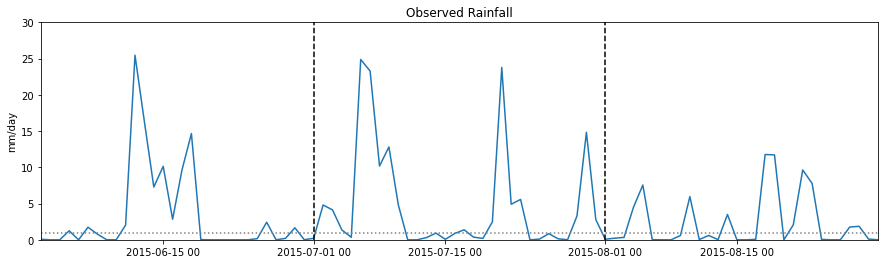

In [36]:
fig,axs = plt.subplots(1,1, figsize=(15,4))
axs.plot(timeArr, nateDS_localDailySum.prec_srf.values)
axs.set_title('Observed Rainfall')
axs.set_ylabel('mm/day')

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs.axhline(1, color = 'grey', linestyle = ':')

axs.set_ylim([0,30])

plt.show()

(1000.0, 200.0)

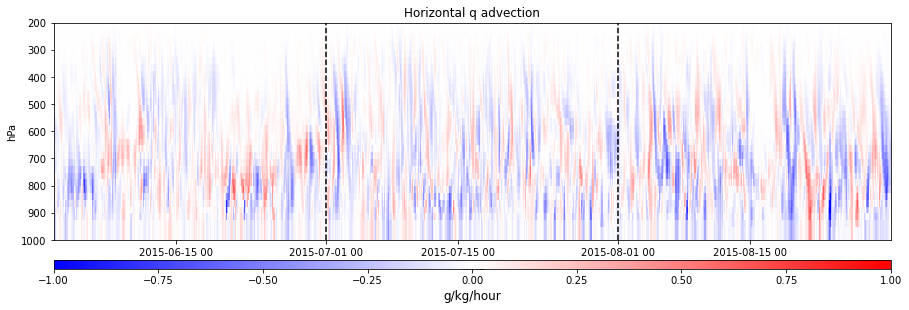

In [88]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(nateDS_HTG.time, nateDS_HTG.lev.values, 
                                np.transpose(np.squeeze(nateDS_HTG.q_adv_h.values)),
                               vmin=-1.0, vmax=1.0,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'bwr')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_HTG.q_adv_h.units,fontsize=12)

startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs.axvline(datetime.date(startYear,8,1), color='k', linestyle='--')
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title(nateDS_HTG.q_adv_h.long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,200])



(1000.0, 200.0)

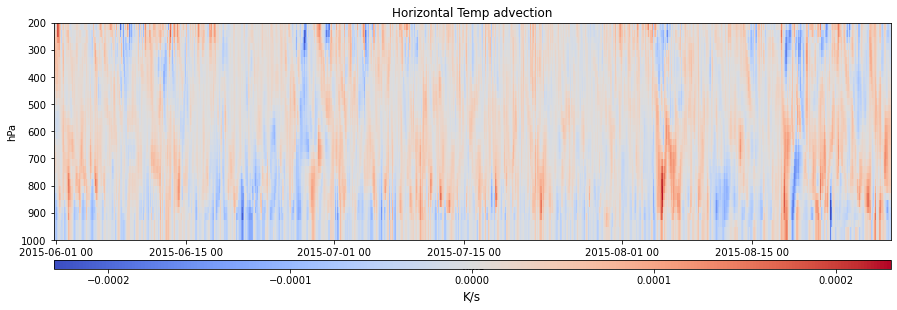

In [62]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(nateDS_HTG.time, nateDS_HTG.lev.values, 
                                np.transpose(np.squeeze(nateDS_HTG.T_adv_h.values)/3600.0),
                               vmin=-2.3e-4, vmax=2.3e-4,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'coolwarm')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('K/s',fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title(nateDS_HTG.T_adv_h.long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,200])




(1000.0, 200.0)

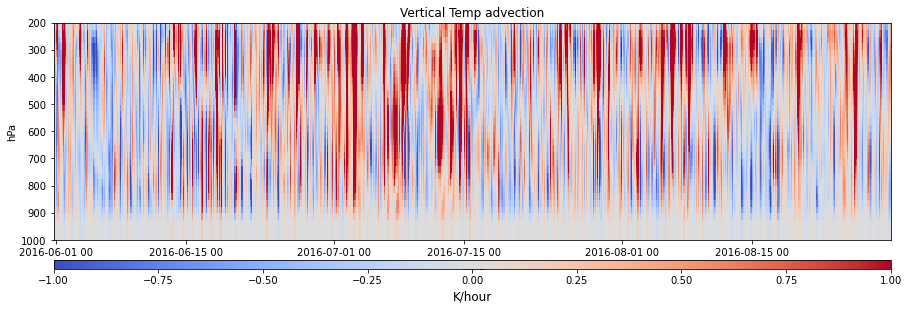

In [68]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(nateDS_HTG.time, nateDS_HTG.lev.values, 
                                np.transpose(np.squeeze(nateDS_HTG.T_adv_v.values)),
                               vmin=-1.0, vmax=1.0,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'coolwarm')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_HTG.T_adv_v.units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2016
endYear    = 2016

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title(nateDS_HTG.T_adv_v.long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,200])





(1000.0, 200.0)

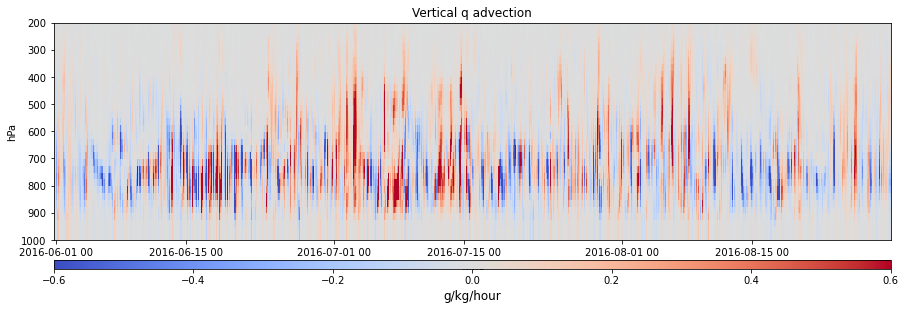

In [67]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(nateDS_HTG.time, nateDS_HTG.lev.values, 
                                np.transpose(np.squeeze(nateDS_HTG.q_adv_v.values)),
                               vmin=-0.6, vmax=0.6,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'coolwarm')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_HTG.q_adv_v.units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2016
endYear    = 2016

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title(nateDS_HTG.q_adv_v.long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,200])






(1000.0, 200.0)

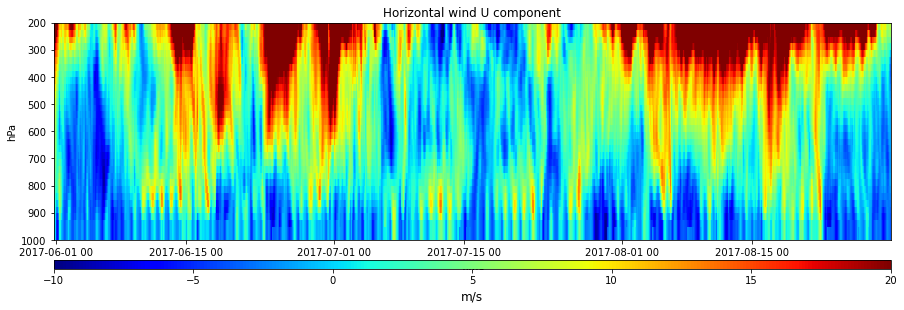

In [51]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(nateDS_HTG.time, nateDS_HTG.lev.values, 
                                np.transpose(np.squeeze(nateDS_HTG.u.values)),
                               vmin=-10, vmax=20,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'jet')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_HTG.u.units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2017
endYear    = 2017

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title(nateDS_HTG.u.long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,200])




(1000.0, 200.0)

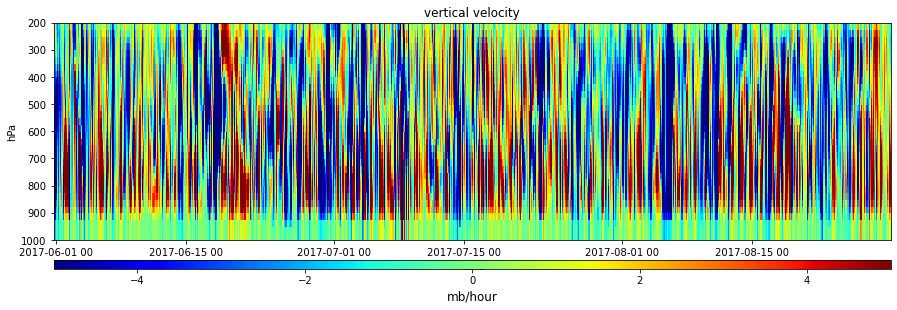

In [44]:
## Plot forcing field

fig,axs = plt.subplots(1,1, figsize=(15,4))
contour_plot   = axs.pcolormesh(nateDS_HTG.time, nateDS_HTG.lev.values, 
                                np.transpose(np.squeeze(nateDS_HTG.omega.values)),
                               vmin=-5, vmax=5,
                              #levels=np.arange(-1.5, 1.55, 0.05),
                       cmap = 'jet')
                             #extend='both')

# Add colorbar 
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_HTG.omega.units,fontsize=12)

startDay   = 31
startMonth = 5
startHr    = 18

endDay     = 30
endMonth   = 8
startYear  = 2017
endYear    = 2017

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

axs.invert_yaxis()

axs.set_title(nateDS_HTG.omega.long_name, fontsize=12)
axs.set_ylabel('hPa')
axs.set_xlabel('Time')
axs.set_ylim([1000,200])







## What does forcing look like on dry/wet days with an artificial surface? 

First define a function to get wWet/dDry days:

In [13]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    classificationArr[0] = 'n/a'
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 

    return(classificationArr)



Also define a function that can take the days that qualify as some classification and get all those dates out of some larger array that's not got the same time units (i.e., hourly or 20m vs. daily resolution)

In [14]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

And a function to plot mean profiles over some range of hours 

In [15]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfilesObs_timeOfDayMean(startHr, endHr, varSel, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryObs = np.where((dDryDays_obs["time.hour"].values>=startHr) & 
                                (dDryDays_obs["time.hour"].values<=endHr))[0]

    hourlyMean_dDryTimeSel_Obs = dDryDays_obs.isel(time=iTimeSel_dDryObs).mean(dim='time')
    hourlyStd_dDryTimeSel_Obs  = dDryDays_obs.isel(time=iTimeSel_dDryObs).std(dim='time')
    stdErr_dDry_Obs = np.squeeze(hourlyStd_dDryTimeSel_Obs[varSel].values)/np.sqrt(len(iTimeSel_dDryObs))
    

    # ------- wWet days ----------
    iTimeSel_wWetObs = np.where((wWetDays_obs["time.hour"].values>=startHr) & 
                                (wWetDays_obs["time.hour"].values<=endHr))[0]

    hourlyMean_wWetTimeSel_Obs = wWetDays_obs.isel(time=iTimeSel_wWetObs).mean(dim='time')
    hourlyStd_wWetTimeSel_Obs  = wWetDays_obs.isel(time=iTimeSel_wWetObs).std(dim='time')
    stdErr_wWet_Obs = np.squeeze(hourlyStd_wWetTimeSel_Obs[varSel].values)/np.sqrt(len(iTimeSel_wWetObs))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs     = axs.ravel()
    
    
    # Plot dDry days 
    axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_Obs[varSel].values), 
                    hourlyMean_dDryTimeSel_Obs['lev'].values,
                    xerr = 2*stdErr_dDry_Obs,
                    fmt='k-', capsize=3, label='Obs')
    axs[0].legend()
    if varSel=='WindMagnitude':
        axs[0].set_title('WindMagnitude\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
        axs[0].set_xlabel(nateDS_local['u'].units)
    else: 
        axs[0].set_title(nateDS_local[varSel].long_name+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
        axs[0].set_xlabel(nateDS_local[varSel].units)
    axs[0].set_ylabel('m')
    
    # Plot wWet days 
    axs[1].errorbar(np.squeeze(hourlyMean_wWetTimeSel_Obs[varSel].values), 
                    hourlyMean_wWetTimeSel_Obs['lev'].values,
                    xerr = 2*stdErr_wWet_Obs,
                    fmt='k-', capsize=3, label='Obs')
    axs[1].legend()
    if varSel=='WindMagnitude':
        axs[1].set_title('WindMagnitude\nwWet days ('+str(startHr)+'-'+str(endHr)+' mean)')
        axs[1].set_xlabel(nateDS_local['u'].units)
    else: 
        axs[1].set_title(nateDS_local[varSel].long_name+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
        axs[1].set_xlabel(nateDS_local[varSel].units)
    
    # Same settings for both subplots
    axs[0].set_ylim([maxLev,1000])
    axs[0].set_xlim([xMin,xMax])
    axs[0].invert_yaxis()
    axs[0].axvline(0, color='g', linestyle='--')
    
    axs[1].set_ylim([maxLev,1000])
    axs[1].set_xlim([xMin,xMax])
    axs[1].invert_yaxis()
    axs[1].axvline(0, color='g', linestyle='--')
    
    
    return 

In [16]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfilesObs_timeOfDayMean_1plot(startHr, endHr, varSel, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryObs = np.where((dDryDays_obs["time.hour"].values>=startHr) & 
                                (dDryDays_obs["time.hour"].values<=endHr))[0]

    hourlyMean_dDryTimeSel_Obs = dDryDays_obs.isel(time=iTimeSel_dDryObs).mean(dim='time')
    hourlyStd_dDryTimeSel_Obs  = dDryDays_obs.isel(time=iTimeSel_dDryObs).std(dim='time')
    print('Mean rainfall on dry days during period: ', dDryDays_obs.prec_srf.values)
    stdErr_dDry_Obs = np.squeeze(hourlyStd_dDryTimeSel_Obs[varSel].values)/np.sqrt(len(iTimeSel_dDryObs))
    

    # ------- wWet days ----------
    iTimeSel_wWetObs = np.where((wWetDays_obs["time.hour"].values>=startHr) & 
                                (wWetDays_obs["time.hour"].values<=endHr))[0]

    hourlyMean_wWetTimeSel_Obs = wWetDays_obs.isel(time=iTimeSel_wWetObs).mean(dim='time')
    hourlyStd_wWetTimeSel_Obs  = wWetDays_obs.isel(time=iTimeSel_wWetObs).std(dim='time')
    print('Mean rainfall on wet days during period: ', wWetDays_obs.prec_srf.values)
    stdErr_wWet_Obs = np.squeeze(hourlyStd_wWetTimeSel_Obs[varSel].values)/np.sqrt(len(iTimeSel_wWetObs))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,1, figsize=(5,4))
    
    
    # Plot dDry days 
    axs.errorbar(np.squeeze(hourlyMean_dDryTimeSel_Obs[varSel].values), 
                    hourlyMean_dDryTimeSel_Obs['lev'].values,
                    xerr = 2*stdErr_dDry_Obs,
                    fmt='-',color='olive', capsize=3, label='DryDays')
    
    # Plot wWet days 
    axs.errorbar(np.squeeze(hourlyMean_wWetTimeSel_Obs[varSel].values), 
                    hourlyMean_wWetTimeSel_Obs['lev'].values,
                    xerr = 2*stdErr_wWet_Obs,
                    fmt='-', color='crimson', capsize=3, label='WetDays')
    
    
    axs.legend()
    
    if varSel=='WindMagnitude':
        axs.set_title('Observed wind speed ('+str(startHr)+'-'+str(endHr)+' mean)')
        axs.set_xlabel(nateDS_local['u'].units)
    else: 
        axs.set_title('Observed '+nateDS_local[varSel].long_name+' ('+str(startHr)+'-'+str(endHr)+' mean)')
        axs.set_xlabel(nateDS_local[varSel].units)
    axs.set_ylabel('hPa')
    
    
    # Same settings for both subplots
    axs.set_ylim([maxLev,1000])
    axs.set_xlim([xMin,xMax])
    axs.invert_yaxis()
    axs.axvline(0, color='k', linestyle='--')
    axs.grid()
    
    
    return 

**Now go ahead and work on the artificial surface part...**

In [ ]:
# ## Convert to local times...
HMGcamDS_localArtificial       = HMGcamDS_allArtifical.copy(deep=True)
HTGcamDS_localArtificial       = HTGcamDS_allArtifical.copy(deep=True)
# HMGclmDS_localArtificial       = HMGclmDS_allArtifical.copy(deep=True)
# HTGclmDS_localArtificial       = HTGclmDS_allArtifical.copy(deep=True)


# # Confirmed that all the times are identical, so using the same local time arrays
# localTimes = HMGcamDS_allArtifical['time'].values - np.timedelta64(5,'h')

# # Replace time dimension with local time
# HMGcamDS_localArtificial = HMGcamDS_localArtificial.assign_coords({"time": localTimes})
# HTGcamDS_localArtificial = HTGcamDS_localArtificial.assign_coords({"time": localTimes})
# HMGclmDS_localArtificial = HMGclmDS_localArtificial.assign_coords({"time": localTimes})
# HTGclmDS_localArtificial = HTGclmDS_localArtificial.assign_coords({"time": localTimes})



In [ ]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_localArtificial['time.year'].values,
                                                                HMGcamDS_localArtificial['time.month'].values, 
                                                                HMGcamDS_localArtificial['time.day'].values])
HMGcamDS_localArtificial.coords['year_month_day'] = ('time', month_day_idx)
# HMGclmDS_localArtificial.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_localArtificial['time.year'].values,
                                                                HTGcamDS_localArtificial['time.month'].values, 
                                                                HTGcamDS_localArtificial['time.day'].values])
HTGcamDS_localArtificial.coords['year_month_day'] = ('time', month_day_idx)
# HTGclmDS_localArtificial.coords['year_month_day'] = ('time', month_day_idx)


In [ ]:
## Get daily means
HMGcamDS_localDailyMeanArtificial = HMGcamDS_localArtificial.groupby('year_month_day').mean()
HTGcamDS_localDailyMeanArtificial = HTGcamDS_localArtificial.groupby('year_month_day').mean()

# HMGclmDS_localDailyMeanArtificial = HMGclmDS_localArtificial.groupby('year_month_day').mean()
# HTGclmDS_localDailyMeanArtificial = HTGclmDS_localArtificial.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
## It's now a 5 min timestep, so changing 1200 to 300
HMGcamDS_localArtificial['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_localArtificial.PRECT.values*300.0*1000.0)
HTGcamDS_localArtificial['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_localArtificial.PRECT.values*300.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySumArtificial = HMGcamDS_localArtificial.groupby('year_month_day').sum()
HTGcamDS_localDailySumArtificial = HTGcamDS_localArtificial.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMeanArtificial['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySumArtificial['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMeanArtificial['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySumArtificial['PRECT_mmPerDT'].values)




In [ ]:
# Define classification by day... 

# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1


classArr_HTG = classifyPrectDays_SCAM(HTGcamDS_localDailySumArtificial.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySumArtificial.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMG = classifyPrectDays_SCAM(HMGcamDS_localDailySumArtificial.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySumArtificial.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 

# Add that classification to larger datasets
HTGcamDS_localDailySumArtificial['dayClass'] = (('year_month_day'), classArr_HTG)
HMGcamDS_localDailySumArtificial['dayClass'] = (('year_month_day'), classArr_HMG)

# Select based on each classification:
idDryArtificial_HTG = np.where(HTGcamDS_localDailySumArtificial['dayClass'].values=='dDry')[0]
idWetArtificial_HTG = np.where(HTGcamDS_localDailySumArtificial['dayClass'].values=='dWet')[0]
iwDryArtificial_HTG = np.where(HTGcamDS_localDailySumArtificial['dayClass'].values=='wDry')[0]
iwWetArtificial_HTG = np.where(HTGcamDS_localDailySumArtificial['dayClass'].values=='wWet')[0]

# HTG_dDry = HTGcamDS_localDailySum.isel(year_month_day = idDry_HTG)
# HTG_dWet = HTGcamDS_localDailySum.isel(year_month_day = idWet_HTG)
# HTG_wDry = HTGcamDS_localDailySum.isel(year_month_day = iwDry_HTG)
# HTG_wWet = HTGcamDS_localDailySum.isel(year_month_day = iwWet_HTG)


idDryArtificial_HMG = np.where(HMGcamDS_localDailySumArtificial['dayClass'].values=='dDry')[0]
idWetArtificial_HMG = np.where(HMGcamDS_localDailySumArtificial['dayClass'].values=='dWet')[0]
iwDryArtificial_HMG = np.where(HMGcamDS_localDailySumArtificial['dayClass'].values=='wDry')[0]
iwWetArtificial_HMG = np.where(HMGcamDS_localDailySumArtificial['dayClass'].values=='wWet')[0]

# HMG_dDry = HMGcamDS_localDailySum.isel(year_month_day = idDry_HMG)
# HMG_dWet = HMGcamDS_localDailySum.isel(year_month_day = idWet_HMG)
# HMG_wDry = HMGcamDS_localDailySum.isel(year_month_day = iwDry_HMG)
# HMG_wWet = HMGcamDS_localDailySum.isel(year_month_day = iwWet_HMG)

## Keep only days that agree on classification between HMG and HTG
setHMG_dDryArtificial = set(idDryArtificial_HMG)
setHTG_dDryArtificial = set(idDryArtificial_HTG)
iKeep_dDryArtificial  = list(setHMG_dDryArtificial & setHTG_dDryArtificial)
HMG_dDryArtificial    = HMGcamDS_localDailySumArtificial.isel(year_month_day = iKeep_dDryArtificial)
HTG_dDryArtificial    = HTGcamDS_localDailySumArtificial.isel(year_month_day = iKeep_dDryArtificial)

# setHMG_dWet = set(idWet_HMG)
# setHTG_dWet = set(idWet_HTG)
# iKeep_dWet  = list(setHMG_dWet & setHTG_dWet)
# HMG_dWetArtificial    = HMGcamDS_localDailySumArtificial.isel(year_month_day = iKeep_dWet)
# HTG_dWetArtificial    = HTGcamDS_localDailySumArtificial.isel(year_month_day = iKeep_dWet)


# setHMG_wDry = set(iwDry_HMG)
# setHTG_wDry = set(iwDry_HTG)
# iKeep_wDry  = list(setHMG_wDry & setHTG_wDry)
# HMG_wDryArtificial    = HMGcamDS_localDailySumArtificial.isel(year_month_day = iKeep_wDry)
# HTG_wDryArtificial    = HTGcamDS_localDailySumArtificial.isel(year_month_day = iKeep_wDry)

setHMG_wWetArtificial = set(iwWetArtificial_HMG)
setHTG_wWetArtificial = set(iwWetArtificial_HTG)
iKeep_wWetArtificial  = list(setHMG_wWetArtificial & setHTG_wWetArtificial)
HMG_wWetArtificial    = HMGcamDS_localDailySumArtificial.isel(year_month_day = iKeep_wWetArtificial)
HTG_wWetArtificial    = HTGcamDS_localDailySumArtificial.isel(year_month_day = iKeep_wWetArtificial)



In [21]:
HMG_dDryArtificial.year_month_day

<xarray.DataArray 'year_month_day' (year_month_day: 97)>
array([(2015, 6, 3), (2015, 6, 4), (2015, 6, 5), (2015, 6, 6), (2015, 6, 7),
       (2015, 6, 8), (2015, 6, 9), (2015, 6, 10), (2015, 6, 11), (2015, 6, 20),
       (2015, 6, 21), (2015, 6, 22), (2015, 6, 23), (2015, 6, 24),
       (2015, 6, 25), (2015, 6, 26), (2015, 6, 27), (2015, 6, 28),
       (2015, 6, 29), (2015, 6, 30), (2015, 7, 1), (2015, 7, 5), (2015, 7, 12),
       (2015, 7, 13), (2015, 7, 14), (2015, 7, 15), (2015, 7, 16),
       (2015, 7, 17), (2015, 7, 18), (2015, 7, 25), (2015, 7, 28),
       (2015, 8, 7), (2015, 8, 8), (2015, 8, 12), (2015, 8, 13), (2015, 8, 16),
       (2016, 6, 6), (2016, 6, 22), (2016, 6, 30), (2016, 7, 11),
       (2016, 7, 14), (2016, 7, 19), (2016, 7, 20), (2016, 7, 21),
       (2016, 7, 22), (2016, 8, 18), (2016, 8, 19), (2016, 8, 23),
       (2017, 6, 7), (2017, 6, 11), (2017, 6, 12), (2017, 6, 21),
       (2017, 6, 22), (2017, 6, 23), (2017, 6, 30), (2017, 7, 7), (2017, 7, 8),
       (2017, 7, 11), (2017, 7, 12), (2017, 7, 13), (2017, 7, 14),
       (2017, 7, 17), (2017, 7, 18), (2017, 7, 19), (2017, 7, 20),
       (2017, 7, 21), (2017, 7, 22), (2017, 7, 23), (2017, 7, 26),
       (2017, 7, 31), (2017, 8, 21), (2018, 6, 3), (2018, 6, 4), (2018, 6, 7),
       (2018, 6, 11), (2018, 6, 12), (2018, 6, 16), (2018, 6, 17),
       (2018, 6, 18), (2018, 6, 30), (2018, 7, 1), (2018, 7, 4), (2018, 7, 5),
       (2018, 7, 6), (2018, 7, 7), (2018, 7, 8), (2018, 7, 9), (2018, 7, 10),
       (2018, 7, 11), (2018, 7, 12), (2018, 7, 13), (2018, 7, 14),
       (2018, 8, 3), (2018, 8, 4), (2018, 8, 5), (2018, 8, 6), (2018, 8, 22)],
      dtype=object)
Coordinates:
  * year_month_day          (year_month_day) MultiIndex
  - year_month_day_level_0  (year_month_day) int64 2015 2015 2015 ... 2018 2018
  - year_month_day_level_1  (year_month_day) int64 6 6 6 6 6 6 6 ... 7 8 8 8 8 8
  - year_month_day_level_2  (year_month_day) int64 3 4 5 6 7 8 ... 14 3 4 5 6 22

In [ ]:
## Get the same dDry and wWet dates in the forcing files 
dDryDays_obs = getTimes_basedOnDayClass(nateDS_local, HTG_dDryArtificial)
wWetDays_obs = getTimes_basedOnDayClass(nateDS_local, HTG_wWetArtificial)


In [ ]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysArtificial_HTG = getTimes_basedOnDayClass(HTGcamDS_localArtificial, HTG_dDryArtificial)
wWetDaysArtificial_HTG = getTimes_basedOnDayClass(HTGcamDS_localArtificial, HTG_wWetArtificial)

dDryDaysArtificial_HMG = getTimes_basedOnDayClass(HMGcamDS_localArtificial, HMG_dDryArtificial)
wWetDaysArtificial_HMG = getTimes_basedOnDayClass(HMGcamDS_localArtificial, HMG_wWetArtificial)


In [ ]:
# Get means a function of hour of day
hourlyMean_dDryArtificial_HMG = dDryDaysArtificial_HMG.groupby("time.hour").mean()
hourlyMean_dDryArtificial_HTG = dDryDaysArtificial_HTG.groupby("time.hour").mean()

hourlyMean_wWetArtificial_HMG = wWetDaysArtificial_HMG.groupby("time.hour").mean()
hourlyMean_wWetArtificial_HTG = wWetDaysArtificial_HTG.groupby("time.hour").mean()

hourlyMean_dDry_Obs  = dDryDays_obs.groupby("time.hour").mean()
hourlyMean_wWet_Obs  = wWetDays_obs.groupby("time.hour").mean()

# Get std as function of hour of day
hourlyStd_dDryArtificial_HMG = dDryDaysArtificial_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dDryArtificial_HTG = dDryDaysArtificial_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wWetArtificial_HMG = wWetDaysArtificial_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wWetArtificial_HTG = wWetDaysArtificial_HTG.groupby("time.hour").std(dim='time')

hourlyStd_dDry_Obs  = dDryDays_obs.groupby("time.hour").std(dim='time')
hourlyStd_wWet_Obs  = wWetDays_obs.groupby("time.hour").std(dim='time')

# Get number of obs going into those hourly means (for error bars)
nTimes_dDryArtificial = np.full([24], np.nan)
nTimes_wWetArtificial = np.full([24], np.nan)

nTimes_dDryObs        = np.full([24], np.nan)
nTimes_wWetObs        = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDryArtificial[iHr] = len(np.where(dDryDaysArtificial_HMG["time.hour"]==iHr)[0])
    nTimes_wWetArtificial[iHr] = len(np.where(wWetDaysArtificial_HMG["time.hour"]==iHr)[0])
    
    nTimes_dDryObs[iHr]        = len(np.where(dDryDays_obs["time.hour"]==iHr)[0])
    nTimes_wWetObs[iHr]        = len(np.where(wWetDays_obs["time.hour"]==iHr)[0])
    
hourlyMean_dDryArtificial_HMG['SampleCount']         = (('hour'), nTimes_dDryArtificial)
hourlyMean_dDryArtificial_HTG['SampleCount']         = (('hour'), nTimes_dDryArtificial)
hourlyMean_dDry_Obs['SampleCount']                   = (('hour'), nTimes_dDryObs)

hourlyMean_wWetArtificial_HMG['SampleCount']         = (('hour'), nTimes_wWetArtificial)
hourlyMean_wWetArtificial_HTG['SampleCount']         = (('hour'), nTimes_wWetArtificial)
hourlyMean_wWet_Obs['SampleCount']                   = (('hour'), nTimes_wWetObs)


In [7]:
nateDS_HTG

<xarray.Dataset>
Dimensions:       (lev: 37, time: 33600)
Coordinates:
  * time          (time) datetime64[ns] 2015-01-01 ... 2018-10-31T22:49:25.42...
  * lev           (lev) float32 1e+03 975.0 950.0 925.0 ... 150.0 125.0 100.0
Data variables:
    base_time     datetime64[ns] ...
    time_offset   (time) datetime64[ns] ...
    year          (time) float64 ...
    month         (time) float64 ...
    day           (time) float64 ...
    hour          (time) float64 ...
    minute        (time) float64 ...
    lat           float32 ...
    lon           float32 ...
    alt           float32 ...
    phis          float32 ...
    T             (time, lev) float32 ...
    q             (time, lev) float32 ...
    u             (time, lev) float32 ...
    v             (time, lev) float32 ...
    omega         (time, lev) float32 ...
    div           (time, lev) float32 ...
    T_adv_h       (time, lev) float32 ...
    T_adv_v       (time, lev) float32 ...
    q_adv_h       (time, lev) float32 ...
    q_adv_v       (time, lev) float32 ...
    s             (time, lev) float32 ...
    s_adv_h       (time, lev) float32 ...
    s_adv_v       (time, lev) float32 ...
    dsdt          (time, lev) float32 ...
    dTdt          (time, lev) float32 ...
    dqdt          (time, lev) float32 ...
    q1            (time, lev) float32 ...
    q2            (time, lev) float32 ...
    prec_srf      (time) float32 ...
    LH            (time) float32 ...
    SH            (time) float32 ...
    p_srf_aver    (time) float32 ...
    p_srf_center  (time) float32 ...
    T_srf         (time) float32 ...
    T_soil        (time) float32 ...
    RH_srf        (time) float32 ...
    wspd_srf      (time) float32 ...
    u_srf         (time) float32 ...
    v_srf         (time) float32 ...
    rad_net_srf   (time) float32 ...
    lw_net_toa    (time) float32 ...
    sw_net_toa    (time) float32 ...
    sw_dn_toa     (time) float32 ...
    cld_low       (time) float32 ...
    cld_mid       (time) float32 ...
    cld_high      (time) float32 ...
    cld_tot       (time) float32 ...
    cld_thick     (time) float32 ...
    cld_top       (time) float32 ...
    LWP           (time) float32 ...
    dh2odt_col    (time) float32 ...
    h2o_adv_col   (time) float32 ...
    evap_srf      (time) float32 ...
    dsdt_col      (time) float32 ...
    s_adv_col     (time) float32 ...
    rad_heat_col  (time) float32 ...
    LH_col        (time) float32 ...
    omega_srf     (time) float32 ...
    q_srf         (time) float32 ...
    s_srf         (time) float32 ...
    PW            (time) float32 ...
    lw_up_srf     (time) float32 ...
    lw_dn_srf     (time) float32 ...
    sw_up_srf     (time) float32 ...
    sw_dn_srf     (time) float32 ...
    T_skin        (time) float32 ...
    TEST          (time) float64 ...
    wpqtp_sfc     (time) float32 ...
    wpthlp_sfc    (time) float32 ...
    qp2           (time) float32 ...
    thlp2         (time) float32 ...
    thlpqp        (time) float32 ...
    wp2           (time) float32 ...
    wp4           (time) float32 ...
    wp2thetap     (time) float32 ...
    wp2qp         (time) float32 ...
    wpqp2         (time) float32 ...
    wpthetap2     (time) float32 ...
    wpthetapqp    (time) float32 ...
    wp3           (time) float32 ...
    upwp          (time) float32 ...
    vpwp          (time) float32 ...
Attributes:
    Conventions:   CF-1.7
    title:         VarAna 1hr RAP_Based v2: SGP 2015-01
    history:       Mon Feb 17 20:27:23 2020: ncrcat sgp60varanarapC1.c1.20150...
    update:        surface LH and SH are merged from ECOR and EBBR instruments
    date_created:  Thu Apr 13 20:12:17 2017
    contact:       Shuaiqi Tang: tang32@llnl.gov, Qi Tang: tang30@llnl.gov, Y...
    program_name:  proc_output_nwp.pro
    institution:   Lawrence Livermore National Laboratory, CA, USA
    references:    https://www.arm.gov/data/data-sources/varanal-29
    note:          Data below the surface are set to lowest a

Mean rainfall on dry days during period:  [-4.8506383e-11 -4.8506383e-11 -4.8506383e-11 ...  2.8621964e-03
  1.7548098e-03  3.5699599e-03]
Mean rainfall on wet days during period:  [2.8806634e+00 2.7844601e+00 2.4809401e+00 ... 5.2024916e-08 5.2024916e-08
 5.2024916e-08]
Means computed over the inclusive period of 7 to 19.


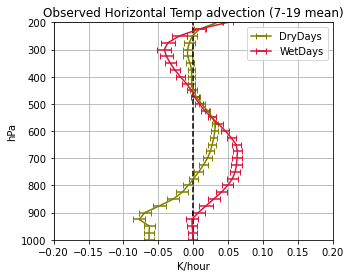

In [25]:
plotProfilesObs_timeOfDayMean_1plot(7,19, 'T_adv_h', 200, -0.2, 0.2)


Mean rainfall on dry days during period:  [-4.8506383e-11 -4.8506383e-11 -4.8506383e-11 ...  2.8621964e-03
  1.7548098e-03  3.5699599e-03]
Mean rainfall on wet days during period:  [2.8806634e+00 2.7844601e+00 2.4809401e+00 ... 5.2024916e-08 5.2024916e-08
 5.2024916e-08]
Means computed over the inclusive period of 11 to 16.


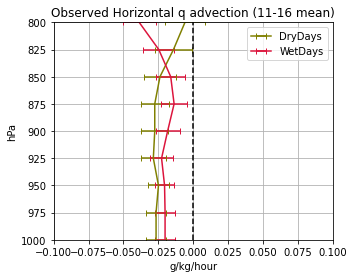

In [45]:
plotProfilesObs_timeOfDayMean_1plot(11,16, 'q_adv_h', 800, -0.1, 0.1)
 

Mean rainfall on dry days during period:  [-4.8506383e-11 -4.8506383e-11 -4.8506383e-11 ...  2.8621964e-03
  1.7548098e-03  3.5699599e-03]
Mean rainfall on wet days during period:  [2.8806634e+00 2.7844601e+00 2.4809401e+00 ... 5.2024916e-08 5.2024916e-08
 5.2024916e-08]
Means computed over the inclusive period of 11 to 16.


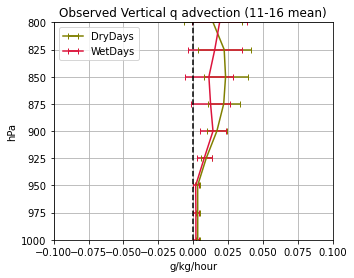

In [44]:
plotProfilesObs_timeOfDayMean_1plot(11,16, 'q_adv_v', 200, -0.1, 0.1)
 

(1000.0, 800.0)

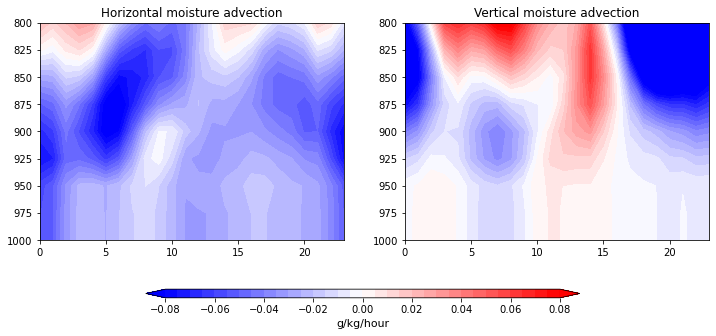

In [40]:
## Time-height plots of Q advection 

## Set up figure
fig,axs = plt.subplots(1,2, figsize=(12,4))
axs     = axs.ravel()    

levsRaw = np.arange(-0.08, 0.085, 0.005)

## Plot raw values 
contour_plot = axs[0].contourf(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs['lev'].values, 
                             np.squeeze(hourlyMean_dDry_Obs['q_adv_h'].values).transpose(),
                             levels=levsRaw, cmap='bwr',extend='both')
axs[0].set_title('Horizontal moisture advection')

contour_plot = axs[1].contourf(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs['lev'].values, 
                             np.squeeze(hourlyMean_dDry_Obs['q_adv_v'].values).transpose(),
                             levels=levsRaw, cmap='bwr',extend='both')
axs[1].set_title('Vertical moisture advection')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.2, ax_position.width+0.15, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local['q_adv_v'].units,fontsize=11)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_ylim([1000,800])
axs[1].set_ylim([1000,800])


Mean rainfall on dry days during period:  [-4.8506383e-11 -4.8506383e-11 -4.8506383e-11 ...  2.8621964e-03
  1.7548098e-03  3.5699599e-03]
Mean rainfall on wet days during period:  [2.8806634e+00 2.7844601e+00 2.4809401e+00 ... 5.2024916e-08 5.2024916e-08
 5.2024916e-08]
Means computed over the inclusive period of 7 to 19.
Mean rainfall on dry days during period:  [-4.8506383e-11 -4.8506383e-11 -4.8506383e-11 ...  2.8621964e-03
  1.7548098e-03  3.5699599e-03]
Mean rainfall on wet days during period:  [2.8806634e+00 2.7844601e+00 2.4809401e+00 ... 5.2024916e-08 5.2024916e-08
 5.2024916e-08]
Means computed over the inclusive period of 7 to 19.


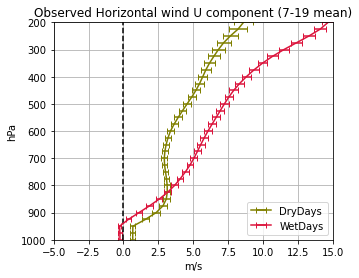

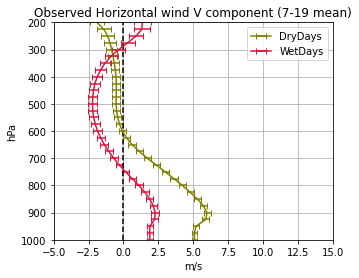

In [34]:
plotProfilesObs_timeOfDayMean_1plot(7,19, 'u', 200, -5, 15)
plotProfilesObs_timeOfDayMean_1plot(7,19, 'v', 200, -5, 15)

Mean rainfall on dry days during period:  [-4.8506383e-11 -4.8506383e-11 -4.8506383e-11 ...  2.8621964e-03
  1.7548098e-03  3.5699599e-03]
Mean rainfall on wet days during period:  [2.8806634e+00 2.7844601e+00 2.4809401e+00 ... 5.2024916e-08 5.2024916e-08
 5.2024916e-08]
Means computed over the inclusive period of 7 to 19.


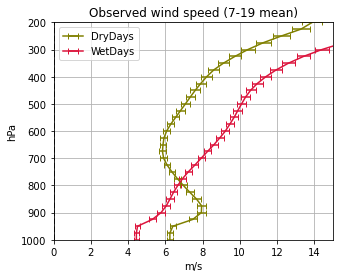

In [35]:
plotProfilesObs_timeOfDayMean_1plot(7,19, 'WindMagnitude', 200, 0, 15)



In [91]:
print('   Mean rain rate (PRECT)')
print('        dDry        wWet')
print('HMG:  %5.2e %11.2e  [m/s]' % (np.nanmean(hourlyMean_dDryArtificial_HMG.PRECT.values), 
                                     np.nanmean(hourlyMean_wWetArtificial_HMG.PRECT.values)) )

print('HTG:  %5.2e %11.2e  [m/s]' % (np.nanmean(hourlyMean_dDryArtificial_HTG.PRECT.values), 
                                     np.nanmean(hourlyMean_wWetArtificial_HTG.PRECT.values)) )

print('Obs:  %5.2e %11.2e  [mm/h]' % (np.nanmean(hourlyMean_dDry_Obs.prec_srf.values), 
                                     np.nanmean(hourlyMean_wWet_Obs.prec_srf.values)) )

   Mean rain rate (PRECT)
        dDry        wWet
HMG:  1.94e-09    1.07e-07  [m/s]
HTG:  2.16e-09    1.08e-07  [m/s]
Obs:  6.21e-02    2.58e-01  [mm/h]


In [119]:
hourlyMean_dDry_Obs

<xarray.Dataset>
Dimensions:       (hour: 24, lev: 37)
Coordinates:
  * hour          (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * lev           (lev) float32 1e+03 975.0 950.0 925.0 ... 150.0 125.0 100.0
Data variables:
    year          (hour) float64 2.016e+03 2.016e+03 ... 2.016e+03 2.016e+03
    month         (hour) float64 6.747 6.745 6.743 6.747 ... 6.771 6.784 6.796
    day           (hour) float64 15.98 15.55 15.14 15.98 ... 16.25 15.37 14.59
    minute        (hour) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lat           (hour) float32 36.61 36.61 36.61 36.61 ... 36.61 36.61 36.61
    lon           (hour) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49 -97.49
    alt           (hour) float32 315.0 315.0 315.0 315.0 ... 315.0 315.0 315.0
    phis          (hour) float32 3.087e+03 3.087e+03 ... 3.087e+03 3.087e+03
    T             (hour, lev) float32 300.2 300.2 300.3 ... 209.7 206.1 204.5
    q             (hour, lev) float32 14.02 14.02 13.88 ... 0.00848 0.00514
    u             (hour, lev) float32 -0.9611 -0.9611 -1.171 ... 6.827 4.348
    v             (hour, lev) float32 8.398 8.398 8.589 ... -3.408 -3.087 -2.696
    omega         (hour, lev) float32 0.04165 0.04165 ... 0.001242 2.882e-05
    div           (hour, lev) float32 1.986e-06 1.986e-06 ... 8.306e-08 -1.1e-07
    T_adv_h       (hour, lev) float32 -0.0506 -0.0506 ... 0.0736 0.05314
    T_adv_v       (hour, lev) float32 -0.004346 -0.004346 ... -1.193e-05
    q_adv_h       (hour, lev) float32 -0.05152 -0.05152 ... -6.887e-06
    q_adv_v       (hour, lev) float32 -0.001956 -0.001956 ... -6.244e-07
    s             (hour, lev) float32 305.4 305.4 305.7 ... 348.5 355.8 367.3
    s_adv_h       (hour, lev) float32 -0.04723 -0.04723 ... 0.05252 0.03533
    s_adv_v       (hour, lev) float32 -0.0003874 -0.0003874 ... 0.002622
    dsdt          (hour, lev) float32 -0.5789 -0.5789 -0.5539 ... 0.0309 0.03319
    dTdt          (hour, lev) float32 -0.5823 -0.5823 ... 0.05199 0.05099
    dqdt          (hour, lev) float32 -0.08103 -0.08103 ... 3.865e-05 2.981e-05
    q1            (hour, lev) float32 -0.5313 -0.5313 ... -0.0232 -0.004768
    q2            (hour, lev) float32 0.06852 0.06852 ... -0.0001107 -9.282e-05
    prec_srf      (hour) float32 0.04928 0.05922 0.07616 ... 0.0549 0.05623
    LH            (hour) float32 8.305 6.399 4.992 4.024 ... 22.83 13.27 10.19
    SH            (hour) float32 -26.38 -23.52 -21.14 ... -33.37 -30.78 -26.84
    p_srf_aver    (hour) float32 970.8 970.8 970.7 970.8 ... 969.8 970.1 970.4
    p_srf_center  (hour) float32 976.7 976.7 976.6 976.6 ... 975.5 976.1 976.4
    T_srf         (hour) float32 24.96 24.25 23.61 23.18 ... 27.87 26.46 25.51
    T_soil        (hour) float32 26.56 26.23 25.92 25.77 ... 27.58 27.2 26.82
    RH_srf        (hour) float32 73.17 75.93 78.38 80.0 ... 61.66 67.5 71.59
    wspd_srf      (hour) float32 3.464 3.34 3.198 3.048 ... 3.714 3.489 3.369
    u_srf         (hour) float32 -0.8407 -0.6079 -0.4108 ... -1.109 -0.9035
    v_srf         (hour) float32 2.78 2.688 2.543 2.37 ... 2.919 2.702 2.604
    rad_net_srf   (hour) float32 -47.99 -46.71 -45.59 ... -25.13 -46.87 -46.35
    lw_net_toa    (hour) float32 264.6 261.9 260.2 259.4 ... 267.5 261.2 256.6
    sw_net_toa    (hour) float32 -2.815e-05 -2.73e-05 ... 0.4931 -2.583e-05
    sw_dn_toa     (hour) float32 1.155e-05 1.106e-05 1.06e-05 ... 1.213 7.54e-06
    cld_low       (hour) float32 1.661 1.323 1.126 1.057 ... 3.947 2.886 2.08
    cld_mid       (hour) float32 5.328 5.488 5.927 5.844 ... 9.039 8.073 8.379
    cld_high      (hour) float32 26.09 27.98 28.57 28.15 ... 24.61 29.77 33.89
    cld_tot       (hour) float32 34.13 35.86 36.72 36.1 ... 39.85 41.99 45.67
    cld_thick     (hour) float32 0.8794 0.928 0.9491 ... 0.9068 1.033 1.128
    cld_top       (hour) float32 6.536 6.785 6.847 6.738 ... 5.732 6.453 6.944
    LWP           (hour) float32 0.003376 0.003528 ... 0.003853 0.003776
    dh2odt_col    (hour) float32 -0.

Text(0, 0.5, 'hPa')

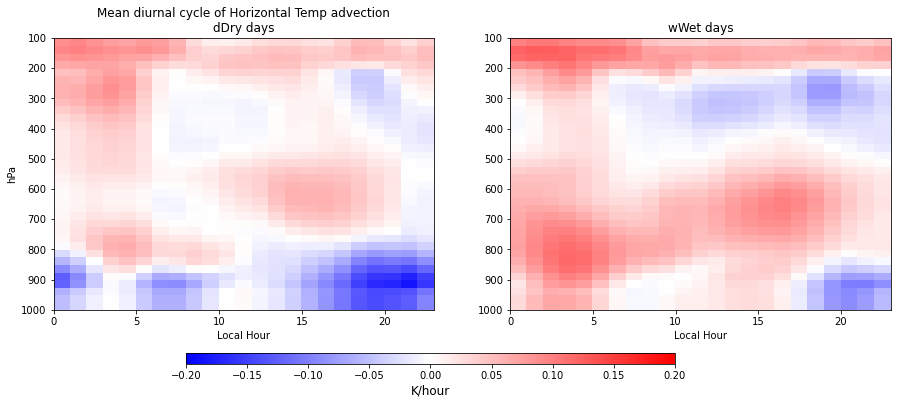

In [29]:
## Now set up figure itself 
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs     = axs.ravel()

varSel = 'T_adv_h'

contour_plot   = axs[0].pcolormesh(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs.lev.values, 
                                   np.transpose(np.squeeze(hourlyMean_dDry_Obs[varSel].values)),
                                   vmin=-0.2, vmax=0.2,
                                   cmap = 'bwr')

contour_plot   = axs[1].pcolormesh(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs.lev.values, 
                                   np.transpose(np.squeeze(hourlyMean_wWet_Obs[varSel].values)),
                                   vmin=-0.2, vmax=0.2,
                                   cmap = 'bwr')

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.15, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local[varSel].units,fontsize=12)

axs[0].set_title('Mean diurnal cycle of '+nateDS_local[varSel].long_name+'\ndDry days')
axs[1].set_title('\nwWet days')

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_xlabel('Local Hour')
axs[1].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')


Text(0, 0.5, 'hPa')

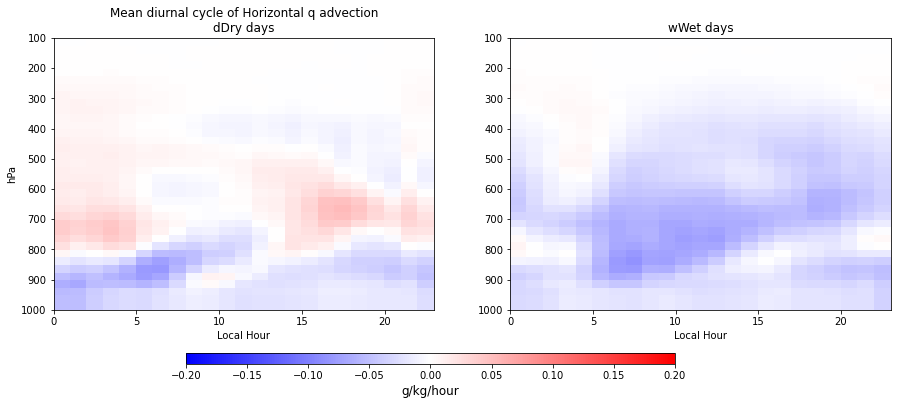

In [30]:
## Now set up figure itself 
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs     = axs.ravel()

varSel = 'q_adv_h'

contour_plot   = axs[0].pcolormesh(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs.lev.values, 
                                   np.transpose(np.squeeze(hourlyMean_dDry_Obs[varSel].values)),
                                   vmin=-0.2, vmax=0.2,
                                   cmap = 'bwr')

contour_plot   = axs[1].pcolormesh(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs.lev.values, 
                                   np.transpose(np.squeeze(hourlyMean_wWet_Obs[varSel].values)),
                                   vmin=-0.2, vmax=0.2,
                                   cmap = 'bwr')

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.15, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local[varSel].units,fontsize=12)

axs[0].set_title('Mean diurnal cycle of '+nateDS_local[varSel].long_name+'\ndDry days')
axs[1].set_title('\nwWet days')

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_xlabel('Local Hour')
axs[1].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')



### The Q advection doesn't make sense for "wet" days... check out more? 

In [30]:
timeArr_model = []
for iT in range(len(HTGcamDS_localDailySumArtificial.year_month_day.values)):
    timeArr_model = np.append(timeArr_model, datetime.date(HTGcamDS_localDailySumArtificial.year_month_day.values[iT][0],
                                               HTGcamDS_localDailySumArtificial.year_month_day.values[iT][1],
                                               HTGcamDS_localDailySumArtificial.year_month_day.values[iT][2]))
    

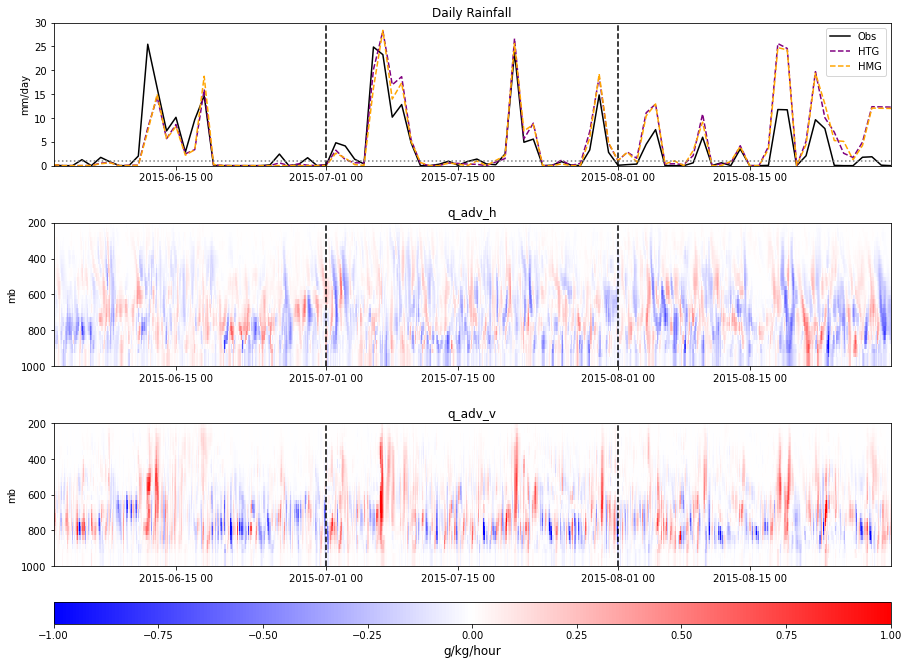

In [33]:
fig,axs = plt.subplots(3,1, figsize=(15,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)


axs[0].plot(timeArr, nateDS_localDailySum.prec_srf.values,'k',label='Obs')
axs[0].plot(timeArr_model, 
            np.squeeze(HTGcamDS_localDailySumArtificial.PRECT_mmPerDT.values), 
            '--',color='purple',label='HTG')
axs[0].plot(timeArr_model, 
            np.squeeze(HMGcamDS_localDailySumArtificial.PRECT_mmPerDT.values), 
            '--',color='orange',label='HMG')
axs[0].set_title('Daily Rainfall')
axs[0].set_ylabel('mm/day')
axs[0].legend()

contour_plot = axs[1].pcolormesh(nateDS_local.time.values, nateDS_local.lev.values, 
                np.transpose(nateDS_local.q_adv_h.values),
                cmap='bwr', 
                vmax = 1.0, vmin=-1.0)
axs[1].set_title('q_adv_h')
axs[1].set_ylabel(nateDS_local.lev.units)
axs[1].invert_yaxis()
axs[1].set_ylim([1000,200])

contour_plot = axs[2].pcolormesh(nateDS_local.time.values, nateDS_local.lev.values, 
                np.transpose(nateDS_local.q_adv_v.values),
                cmap='bwr', 
                vmax = 1.0, vmin=-1.0)
axs[2].set_title('q_adv_v')
axs[2].set_ylabel(nateDS_local.lev.units)
axs[2].invert_yaxis()
axs[2].set_ylim([1000,200])

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local['q_adv_h'].units,fontsize=12)

# Limit time axis
startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2015
endYear    = 2015

axs[0].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[1].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[2].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[0].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')
axs[0].axhline(1, color = 'grey', linestyle = ':')
axs[0].set_ylim([0,30])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[1].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[2].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[2].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

plt.show()

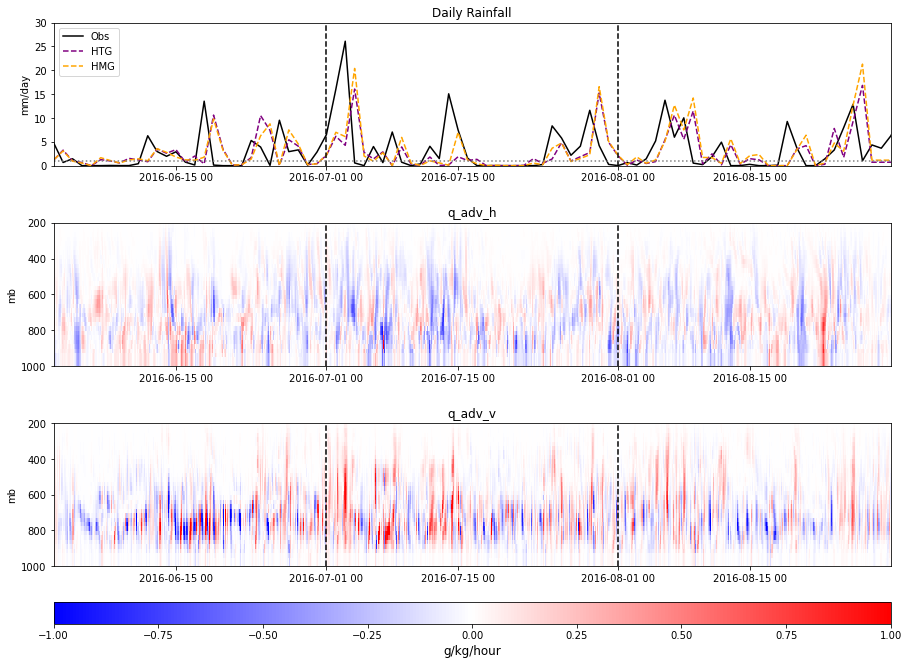

In [36]:
fig,axs = plt.subplots(3,1, figsize=(15,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)


axs[0].plot(timeArr, nateDS_localDailySum.prec_srf.values,'k',label='Obs')
axs[0].plot(timeArr_model, 
            np.squeeze(HTGcamDS_localDailySumArtificial.PRECT_mmPerDT.values), 
            '--',color='purple',label='HTG')
axs[0].plot(timeArr_model, 
            np.squeeze(HMGcamDS_localDailySumArtificial.PRECT_mmPerDT.values), 
            '--',color='orange',label='HMG')
axs[0].set_title('Daily Rainfall')
axs[0].set_ylabel('mm/day')
axs[0].legend()

contour_plot = axs[1].pcolormesh(nateDS_local.time.values, nateDS_local.lev.values, 
                np.transpose(nateDS_local.q_adv_h.values),
                cmap='bwr', 
                vmax = 1.0, vmin=-1.0)
axs[1].set_title('q_adv_h')
axs[1].set_ylabel(nateDS_local.lev.units)
axs[1].invert_yaxis()
axs[1].set_ylim([1000,200])

contour_plot = axs[2].pcolormesh(nateDS_local.time.values, nateDS_local.lev.values, 
                np.transpose(nateDS_local.q_adv_v.values),
                cmap='bwr', 
                vmax = 1.0, vmin=-1.0)
axs[2].set_title('q_adv_v')
axs[2].set_ylabel(nateDS_local.lev.units)
axs[2].invert_yaxis()
axs[2].set_ylim([1000,200])

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local['q_adv_h'].units,fontsize=12)

# Limit time axis
startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2016
endYear    = 2016

axs[0].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[1].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[2].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[0].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')
axs[0].axhline(1, color = 'grey', linestyle = ':')
axs[0].set_ylim([0,30])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[1].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[2].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[2].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

plt.show()

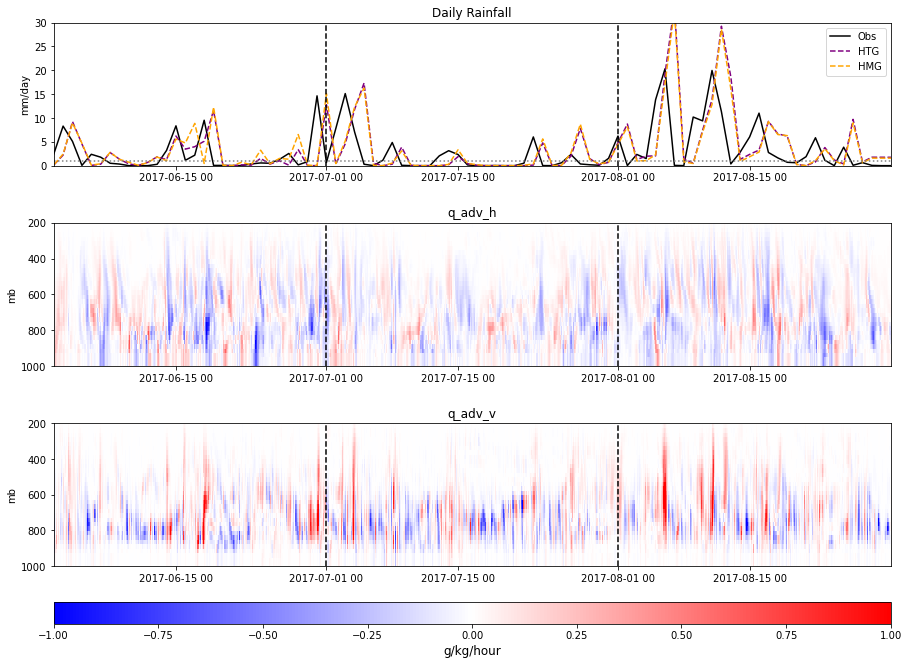

In [37]:
fig,axs = plt.subplots(3,1, figsize=(15,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)


axs[0].plot(timeArr, nateDS_localDailySum.prec_srf.values,'k',label='Obs')
axs[0].plot(timeArr_model, 
            np.squeeze(HTGcamDS_localDailySumArtificial.PRECT_mmPerDT.values), 
            '--',color='purple',label='HTG')
axs[0].plot(timeArr_model, 
            np.squeeze(HMGcamDS_localDailySumArtificial.PRECT_mmPerDT.values), 
            '--',color='orange',label='HMG')
axs[0].set_title('Daily Rainfall')
axs[0].set_ylabel('mm/day')
axs[0].legend()

contour_plot = axs[1].pcolormesh(nateDS_local.time.values, nateDS_local.lev.values, 
                np.transpose(nateDS_local.q_adv_h.values),
                cmap='bwr', 
                vmax = 1.0, vmin=-1.0)
axs[1].set_title('q_adv_h')
axs[1].set_ylabel(nateDS_local.lev.units)
axs[1].invert_yaxis()
axs[1].set_ylim([1000,200])

contour_plot = axs[2].pcolormesh(nateDS_local.time.values, nateDS_local.lev.values, 
                np.transpose(nateDS_local.q_adv_v.values),
                cmap='bwr', 
                vmax = 1.0, vmin=-1.0)
axs[2].set_title('q_adv_v')
axs[2].set_ylabel(nateDS_local.lev.units)
axs[2].invert_yaxis()
axs[2].set_ylim([1000,200])

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local['q_adv_h'].units,fontsize=12)

# Limit time axis
startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2017
endYear    = 2017

axs[0].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[1].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[2].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[0].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')
axs[0].axhline(1, color = 'grey', linestyle = ':')
axs[0].set_ylim([0,30])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[1].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[2].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[2].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

plt.show()

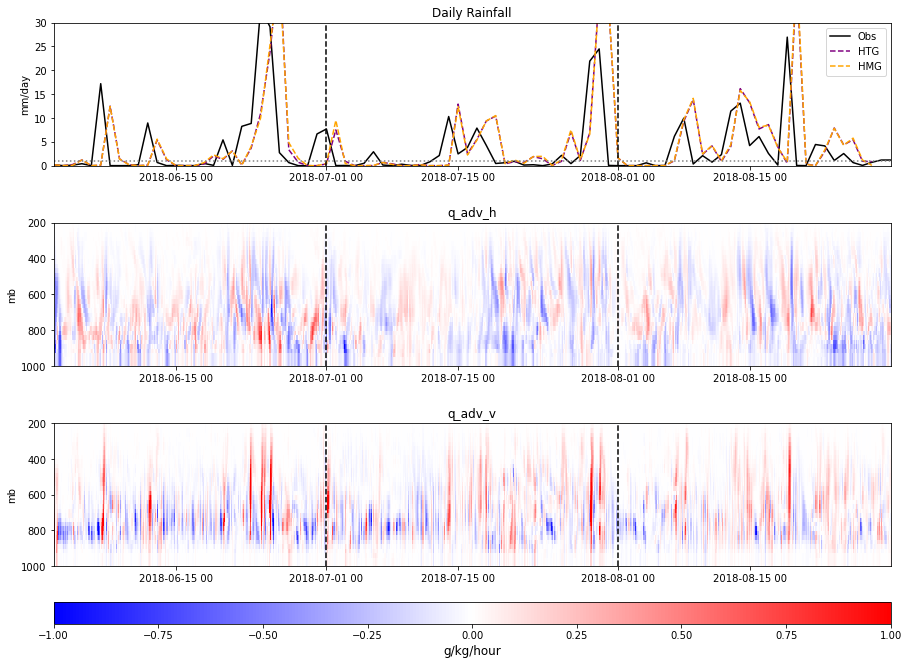

In [38]:
fig,axs = plt.subplots(3,1, figsize=(15,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)


axs[0].plot(timeArr, nateDS_localDailySum.prec_srf.values,'k',label='Obs')
axs[0].plot(timeArr_model, 
            np.squeeze(HTGcamDS_localDailySumArtificial.PRECT_mmPerDT.values), 
            '--',color='purple',label='HTG')
axs[0].plot(timeArr_model, 
            np.squeeze(HMGcamDS_localDailySumArtificial.PRECT_mmPerDT.values), 
            '--',color='orange',label='HMG')
axs[0].set_title('Daily Rainfall')
axs[0].set_ylabel('mm/day')
axs[0].legend()

contour_plot = axs[1].pcolormesh(nateDS_local.time.values, nateDS_local.lev.values, 
                np.transpose(nateDS_local.q_adv_h.values),
                cmap='bwr', 
                vmax = 1.0, vmin=-1.0)
axs[1].set_title('q_adv_h')
axs[1].set_ylabel(nateDS_local.lev.units)
axs[1].invert_yaxis()
axs[1].set_ylim([1000,200])

contour_plot = axs[2].pcolormesh(nateDS_local.time.values, nateDS_local.lev.values, 
                np.transpose(nateDS_local.q_adv_v.values),
                cmap='bwr', 
                vmax = 1.0, vmin=-1.0)
axs[2].set_title('q_adv_v')
axs[2].set_ylabel(nateDS_local.lev.units)
axs[2].invert_yaxis()
axs[2].set_ylim([1000,200])

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local['q_adv_h'].units,fontsize=12)

# Limit time axis
startDay   = 2
startMonth = 6
startHr    = 0

endDay     = 30
endMonth   = 8
startYear  = 2018
endYear    = 2018

axs[0].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[1].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
axs[2].set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[0].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[0].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')
axs[0].axhline(1, color = 'grey', linestyle = ':')
axs[0].set_ylim([0,30])

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[1].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[1].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 
axs[2].axvline(datetime.date(startYear,7,1), color='k', linestyle='--')
axs[2].axvline(datetime.date(startYear,8,1), color='k', linestyle='--')

plt.show()

## What does forcing look like on dry/wet days with a *realistic* surface?

In [84]:
## Convert to local times...
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)
HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
HMGclmDS_local       = HMGclmDS_all.copy(deep=True)
HTGclmDS_local       = HTGclmDS_all.copy(deep=True)


# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGclmDS_local = HMGclmDS_local.assign_coords({"time": localTimes})
HTGclmDS_local = HTGclmDS_local.assign_coords({"time": localTimes})


In [85]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local['time.year'].values,
                                                                HMGcamDS_local['time.month'].values, 
                                                                HMGcamDS_local['time.day'].values])
HMGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local['time.year'].values,
                                                                HTGcamDS_local['time.month'].values, 
                                                                HTGcamDS_local['time.day'].values])
HTGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)


In [86]:
## Get daily means
HMGcamDS_localDailyMean = HMGcamDS_local.groupby('year_month_day').mean()
HTGcamDS_localDailyMean = HTGcamDS_local.groupby('year_month_day').mean()

HMGclmDS_localDailyMean = HMGclmDS_local.groupby('year_month_day').mean()
HTGclmDS_localDailyMean = HTGclmDS_local.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)



In [87]:
# Define classification by day... 

# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1


classArr_HTG = classifyPrectDays_SCAM(HTGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMG = classifyPrectDays_SCAM(HMGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 

# Add that classification to larger datasets
HTGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HTG)
HMGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HMG)

# Select based on each classification:
idDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wWet')[0]

# HTG_dDry = HTGcamDS_localDailySum.isel(year_month_day = idDry_HTG)
# HTG_dWet = HTGcamDS_localDailySum.isel(year_month_day = idWet_HTG)
# HTG_wDry = HTGcamDS_localDailySum.isel(year_month_day = iwDry_HTG)
# HTG_wWet = HTGcamDS_localDailySum.isel(year_month_day = iwWet_HTG)


idDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wWet')[0]

# HMG_dDry = HMGcamDS_localDailySum.isel(year_month_day = idDry_HMG)
# HMG_dWet = HMGcamDS_localDailySum.isel(year_month_day = idWet_HMG)
# HMG_wDry = HMGcamDS_localDailySum.isel(year_month_day = iwDry_HMG)
# HMG_wWet = HMGcamDS_localDailySum.isel(year_month_day = iwWet_HMG)

## Keep only days that agree on classification between HMG and HTG
setHMG_dDry = set(idDry_HMG)
setHTG_dDry = set(idDry_HTG)
iKeep_dDry  = list(setHMG_dDry & setHTG_dDry)
HMG_dDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)
HTG_dDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)


setHMG_dWet = set(idWet_HMG)
setHTG_dWet = set(idWet_HTG)
iKeep_dWet  = list(setHMG_dWet & setHTG_dWet)
HMG_dWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)
HTG_dWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)


setHMG_wDry = set(iwDry_HMG)
setHTG_wDry = set(iwDry_HTG)
iKeep_wDry  = list(setHMG_wDry & setHTG_wDry)
HMG_wDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)
HTG_wDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)


setHMG_wWet = set(iwWet_HMG)
setHTG_wWet = set(iwWet_HTG)
iKeep_wWet  = list(setHMG_wWet & setHTG_wWet)
HMG_wWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)
HTG_wWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)




In [129]:
del dDryDays_obs
del wWetDays_obs

## Get the same dDry and wWet dates in the forcing files 
dDryDays_obs = getTimes_basedOnDayClass(nateDS_local, HTG_dDry)
wWetDays_obs = getTimes_basedOnDayClass(nateDS_local, HTG_wWet)


In [130]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dDry)
wWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wWet)

dDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dDry)
wWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wWet)



In [131]:
# Get means a function of hour of day
hourlyMean_dDry_HMG = dDryDays_HMG.groupby("time.hour").mean()
hourlyMean_dDry_HTG = dDryDays_HTG.groupby("time.hour").mean()

hourlyMean_wWet_HMG = wWetDays_HMG.groupby("time.hour").mean()
hourlyMean_wWet_HTG = wWetDays_HTG.groupby("time.hour").mean()

hourlyMean_dDry_Obs  = dDryDays_obs.groupby("time.hour").mean()
hourlyMean_wWet_Obs  = wWetDays_obs.groupby("time.hour").mean()

# Get std as function of hour of day
hourlyStd_dDry_HMG = dDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTG = dDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMG = wWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTG = wWetDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_dDry_Obs  = dDryDays_obs.groupby("time.hour").std(dim='time')
hourlyStd_wWet_Obs  = wWetDays_obs.groupby("time.hour").std(dim='time')

# Get number of obs going into those hourly means (for error bars)
nTimes_dDry = np.full([24], np.nan)
nTimes_wWet = np.full([24], np.nan)

nTimes_dDryObs = np.full([24], np.nan)
nTimes_wWetObs = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDry[iHr] = len(np.where(dDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_wWet[iHr] = len(np.where(wWetDays_HMG["time.hour"]==iHr)[0])
    
    nTimes_dDryObs[iHr]  = len(np.where(dDryDays_obs["time.hour"]==iHr)[0])
    nTimes_wWetObs[iHr]  = len(np.where(wWetDays_obs["time.hour"]==iHr)[0])
    
hourlyMean_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
hourlyMean_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)
hourlyMean_dDry_Obs['SampleCount']         = (('hour'), nTimes_dDryObs)

hourlyMean_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
hourlyMean_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)
hourlyMean_wWet_Obs['SampleCount']         = (('hour'), nTimes_wWetObs)




Means computed over the inclusive period of 15 to 17.


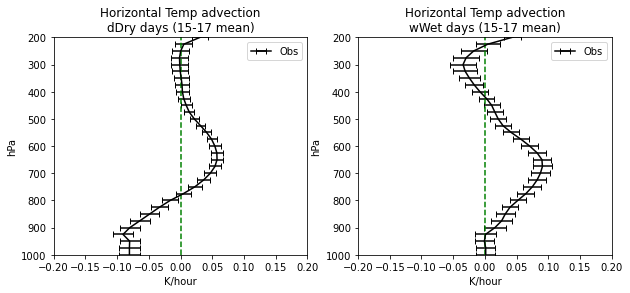

In [91]:
plotProfilesObs_timeOfDayMean(15,17, 'T_adv_h', 200, -0.2, 0.2)


Means computed over the inclusive period of 15 to 17.


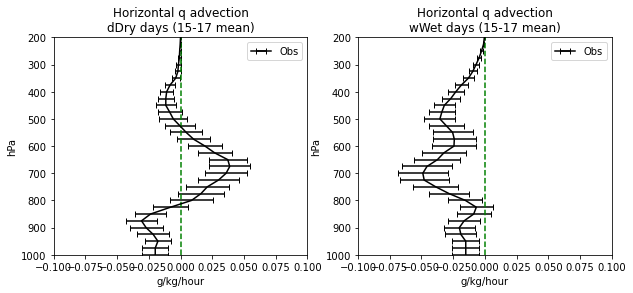

In [92]:
plotProfilesObs_timeOfDayMean(15,17, 'q_adv_h', 200, -0.1, 0.1)


Text(0, 0.5, 'hPa')

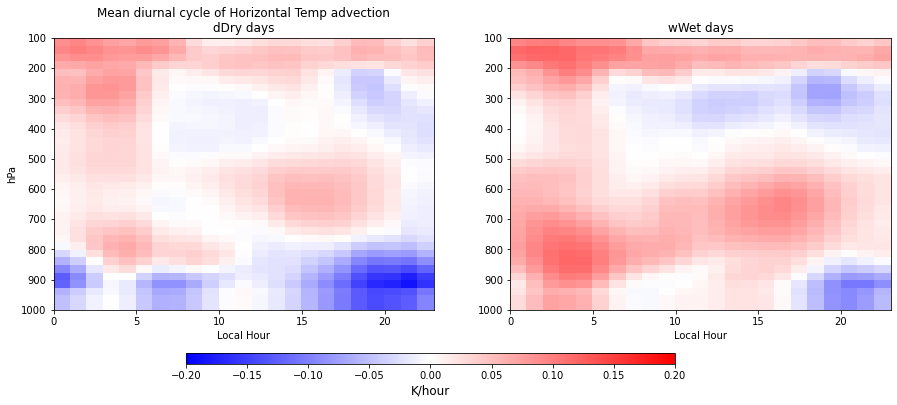

In [132]:
## Now set up figure itself 
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs     = axs.ravel()

varSel = 'T_adv_h'

contour_plot   = axs[0].pcolormesh(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs.lev.values, 
                                   np.transpose(np.squeeze(hourlyMean_dDry_Obs[varSel].values)),
                                   vmin=-0.2, vmax=0.2,
                                   cmap = 'bwr')

contour_plot   = axs[1].pcolormesh(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs.lev.values, 
                                   np.transpose(np.squeeze(hourlyMean_wWet_Obs[varSel].values)),
                                   vmin=-0.2, vmax=0.2,
                                   cmap = 'bwr')

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.15, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local[varSel].units,fontsize=12)

axs[0].set_title('Mean diurnal cycle of '+nateDS_local[varSel].long_name+'\ndDry days')
axs[1].set_title('\nwWet days')

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_xlabel('Local Hour')
axs[1].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')



Text(0, 0.5, 'hPa')

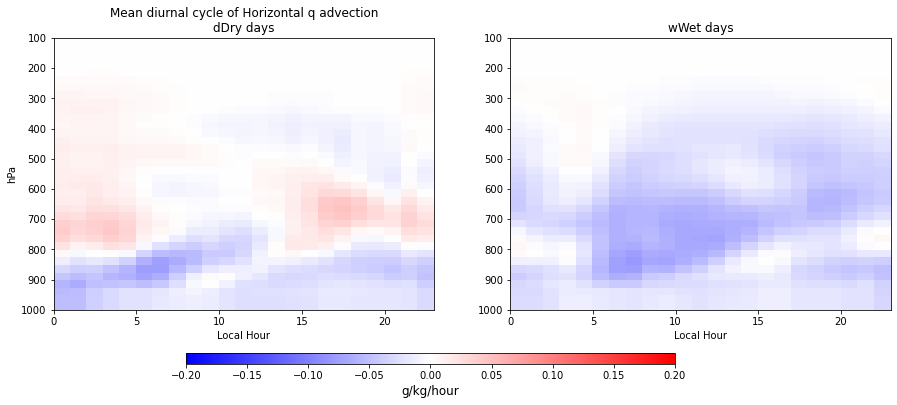

In [133]:
## Now set up figure itself 
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs     = axs.ravel()

varSel = 'q_adv_h'

contour_plot   = axs[0].pcolormesh(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs.lev.values, 
                                   np.transpose(np.squeeze(hourlyMean_dDry_Obs[varSel].values)),
                                   vmin=-0.2, vmax=0.2,
                                   cmap = 'bwr')

contour_plot   = axs[1].pcolormesh(hourlyMean_dDry_Obs.hour.values, hourlyMean_dDry_Obs.lev.values, 
                                   np.transpose(np.squeeze(hourlyMean_wWet_Obs[varSel].values)),
                                   vmin=-0.2, vmax=0.2,
                                   cmap = 'bwr')

# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.15, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(nateDS_local[varSel].units,fontsize=12)

axs[0].set_title('Mean diurnal cycle of '+nateDS_local[varSel].long_name+'\ndDry days')
axs[1].set_title('\nwWet days')

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_xlabel('Local Hour')
axs[1].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')


